# DEMO: Stackoverflow dump

## CURARE view model

In [31]:
%matplotlib inline
import os 
from pyspark import SparkContext
from pyspark.mllib.stat import Statistics
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib
import datetime as dt
import statistics
from scipy import stats
import nltk
import ipywidgets as widgets
import pandas
from collections import Counter
from numpy import NaN

### View Class

In [2]:
class View:
    _id = "" # url
    name = ""
    provider = ""
    author = ""
    description = ""        
    code = ""
    rules = ""
    source = ""    
    releaseViewList = []
 
    def __init__(self, _id, name, provider, author, description, code, rules, source, releaseViewList):
        self._id = _id
        self.name = name
        self.provider = provider
        self.author = author
        self.description = description
        self.code = code
        self.rules = rules
        self.source = source
        self.releaseViewList = releaseViewList
 
    def printInfo(self):
        print ("_id = " + str(self._id))
        print ("name = " + str(self.name))
        print ("provider = " + str(self.provider))
        print ("author = " + str(self.author))
        print ("description = " + str(self.description))
        print ("code = " + str(self.code))
        print ("rules = " + str(self.rules))
        print ("source = " + str(self.source))
        print ("list of release views = " + str(self.releaseViewList))    
        
print ("Success class created!")

Success class created!


### Release View Class

In [3]:
class ReleaseView:
    _id = "" # url
    version = 0
    publicationDate = ""
    size = 0
    licence = ""                
 
    def __init__(self, _id, version, publicationDate, size, license, attributeDescList):
        self._id = _id
        self.version = version
        self.publicationDate = publicationDate
        self.size = size
        self.license = license        
        self.attributeDescList = attributeDescList        
 
    def printInfo(self):
        print ("_id  = " + str(self._id))
        print ("name  = " + str(self.name))
        print ("provider  = " + str(self.provider))
        print ("author  = " + str(self.author))
        print ("description  = " + str(self.description))
        print ("code  = " + str(self.code))
        print ("rules  = " + str(self.rules))
        print ("source  = " + str(self.source))
        print ("default  = " + str(self.default))
        print ("list of release views = " + str(self.releaseViewList)) 
        
print ("Success class created!")

Success class created!


### Attribute Descriptor Class

In [4]:
# One instance per item
class AttributeDescriptor:
    _id = "" # should be the same as the one in data collection model. Created by mongo
    name = "" # name of the item
    _type = [] # maybe take from data collection model
    valueDistribution = [] # Histogram
    nullValue = 0               
    absentValue = 0 
    minValue = []
    maxValue = []
    mean = []
    median = []
    mode = []
    count = 0
 
    def __init__(self, _id, name, _type, valueDistribution, nullValue, absentValue, minValue, maxValue, mean, median, mode, count):
        self._id = _id
        self.name = name
        self._type = _type
        self.valueDistribution = valueDistribution
        self.nullValue = nullValue
        self.absentValue = absentValue
        self.minValue = minValue
        self.maxValue = maxValue
        self.mean = mean
        self.median = median
        self.mode = mode
        self.count = count
 
    def printInfo(self):
        print ("_id = " + str(self._id))
        print ("name = " + str(self.name))
        print ("_type = " + str(self._type))
        print ("valueDistribution = " + str(self.valueDistribution))
        print ("nullValue = " + str(self.nullValue))
        print ("absentValue = " + str(self.absentValue))
        print ("minValue = " + str(self.minValue))
        print ("maxValue = " + str(self.maxValue))
        print ("mean = " + str(self.mean))
        print ("median = " + str(self.median))
        print ("mode = " + str(self.mode)) 
        print ("count = " + str(self.count)) 
        
print ("Success class created!")

Success class created!


### Unarchiving

In [5]:
import urllib.request
import shutil
from os import listdir
import zipfile

def dwnldUrl (_url, folder_name, file_name):            
    
    file_name = '/tmp/' + file_name # file will be downloaded in this location
    # Download the file from 'url' and save it locally under 'file_name':
    with urllib.request.urlopen(_url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)            
    
    # Unarchive data
    zip_ref = zipfile.ZipFile(file_name, 'r')
    zip_ref.extractall('/tmp/' + folder_name) # creates folder f1db_csv if it doesn't exist
    zip_ref.close()

    listFilePath = []
    
    for f in os.listdir('/tmp/' + folder_name):     
        listFilePath.append('/tmp/' + folder_name + f)
    
    return listFilePath

def getLocalFiles(_path):    
    for f in os.listdir(_path):     
        listFilePath.append(_path + f)
    
    return listFilePath

In [6]:
selSource = widgets.Select(
    options=['Download from URL', 'Local Files'],
    value='Local Files',
    rows=3,
    description='Source:',
    disabled=False
)
selSource

Select(description='Source:', index=1, options=('Download from URL', 'Local Files'), rows=3, value='Local File…

In [7]:
listFilePath = []
if selSource.value == 'Local Files':
    listFilePath = getLocalFiles("/test/stackexchange/release_09-10-18/cut/")
    for f in listFilePath:     
        print (f)    
    
elif selSource.value == 'Download from URL':
    listFilePath = dwnldUrl("http://ergast.com/downloads/f1db_csv.zip", "f1/", "f1db_csv.zip")
    for f in listFilePath:     
        print (f)

else:
    print ('any')

/test/stackexchange/release_09-10-18/cut/Badges.csv
/test/stackexchange/release_09-10-18/cut/Comments.csv
/test/stackexchange/release_09-10-18/cut/PostHistory.csv
/test/stackexchange/release_09-10-18/cut/PostLinks.csv
/test/stackexchange/release_09-10-18/cut/Posts.csv
/test/stackexchange/release_09-10-18/cut/Tags.csv
/test/stackexchange/release_09-10-18/cut/Users.csv
/test/stackexchange/release_09-10-18/cut/Votes.csv


### Functions to retrive attribute values

#### Get type

In [8]:
def getType (filePath):            
        
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath) 
    return df.dtypes # list N-tuple <attribute, data type>

#getType("/test/stackexchange/release_09-10-18/csv/Badges.csv")

#### Get histogram

In [44]:
def getHist (filePath):            
        
    histList = []

    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath) 
    
    for x in range(0,len(df.columns)):  

        column_sel = df.select((df.columns[x])).collect()
        column_name = df.dtypes[x][0]
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)                                    
        
        if column_type == "int":
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0            
                        
            _hist = plt.hist(column_array) 
            plt.xlabel(column_name)
            plt.ylabel("frequency")
            plt.show() 
            histList.append(_hist) 
                                
        elif column_type == "string" or column_type == "boolean" or column_type == "timestamp":  
            
            if column_type == "timestamp":
                for n, i in enumerate(column_array):
                    item = str(i)
                    column_array[n] = item
            
            dataf = pandas.DataFrame.from_dict(Counter(column_sel), orient='index')
            p = dataf.plot(kind='bar', rot=90)
            p.set_xlabel(column_name)
            p.set_ylabel("frequency")   
            plt.show()            
            histList.append(dataf) 
            
        else:
            histList.append(None)                        
        
    return histList

#getHist("/test/stackexchange/release_09-10-18/csv/Badges.csv")

#### Get number of null values

In [10]:
def getNull (filePath):            
        
    nullList = []
    
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath) 

    for x in range(0,len(df.columns)):   
        
        column_sel = df.select((df.columns[x])).collect()
        column_array = np.array(column_sel)
        column_par = sc.parallelize(column_array) # an RDD of arrays                                                   
        
        nulls = column_par.filter(lambda s: None in s).count() 
        nullList.append(nulls)        
                
    return nullList

#getNull("/test/stackexchange/release_09-10-18/csv/Tags.csv")

#### Get number of absent values

In [11]:
def getAbsent (filePath):            
        
    absentList = []
    
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath) 
        
    for x in range(0,len(df.columns)):   
        
        column_sel = df.select((df.columns[x])).collect()
        column_array = np.array(column_sel)        
        column_par = sc.parallelize(column_array) # an RDD of arrays               
        
        emptys = column_par.filter(lambda s: "''" in s).count() 
        absentList.append(emptys)
                
    return absentList   

#getAbsent("/test/stackexchange/release_09-10-18/csv/Tags - Copy.csv")

#### Get min value per column

In [22]:
def getMinVal (filePath):                    
        
    minValList = []    

    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)       

    for x in range(0,len(df.columns)): 
                      
        column_sel = df.select((df.columns[x])).collect()
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)             
        
        if column_type == "int":  
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0
                               
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            minValList.append(int(summary.min()[0]))         
            
        elif column_type == "boolean":
            for n, i in enumerate(column_array):
                if i == False:
                    column_array[n] = 0
                elif i == True:
                    column_array[n] = 1
                    
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            minValList.append(int(summary.min()[0])) 
            
        elif (column_type == "string" or column_type == "timestamp") and column_type is not dt.datetime: 
                                     
            # Convert boolean to string
            if column_type == "timestamp":                
                for n, i in enumerate(column_array):
                    item = str(i)
                    column_array[n] = item
                                                    
            wList = []
            fnpC = column_array.flatten()            
                      
            # get string lenght and creates a list
            for i in fnpC:
                if i is not None:
                    wList.append(len(i))
                elif i is None:
                    wList.append(0)
                else:
                    wList.append(i)                                                                                                                           
                                                                                                                           
            minValList.append(min(wList))  
            
        else:
            minValList.append(None)        
        
    return minValList

#getMinVal("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Get max value per column

In [35]:
def getMaxVal (filePath):                    
        
    maxValList = []

    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)       

    for x in range(0,len(df.columns)): 
                      
        column_sel = df.select((df.columns[x])).collect()
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)             
        
        if column_type == "int":  
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0
                               
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            maxValList.append(int(summary.max()[0]))         
            
        elif column_type == "boolean":
            for n, i in enumerate(column_array):
                if i == False:
                    column_array[n] = 0
                elif i == True:
                    column_array[n] = 1
                    
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            maxValList.append(int(summary.max()[0])) 
            
        elif (column_type == "string" or column_type == "timestamp") and column_type is not dt.datetime: 
                                     
            # Convert boolean to string
            if column_type == "timestamp":                
                for n, i in enumerate(column_array):
                    item = str(i)                                                            
                    column_array[n] = item
                                                    
            wList = []
            fnpC = column_array.flatten()            
                      
            # get string lenght and creates a list
            for i in fnpC:
                if i is not None:
                    wList.append(len(i))
                elif i is None:
                    wList.append(0)
                else:
                    wList.append(i)                                                                                                                           
                                                                                                                           
            maxValList.append(max(wList))  
            
        else:
            maxValList.append(None)        
        
    return maxValList

#getMaxVal("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Get mean value per column

In [24]:
def getMeanVal (filePath):                    
        
    meanValList = []

    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)       

    for x in range(0,len(df.columns)): 
                      
        column_sel = df.select((df.columns[x])).collect()
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)             
        
        if column_type == "int":      
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0
                               
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            meanValList.append(int(summary.mean()[0]))         
            
        elif column_type == "boolean":
            for n, i in enumerate(column_array):
                if i == False:
                    column_array[n] = 0
                elif i == True:
                    column_array[n] = 1
                    
            column_c = sc.parallelize(column_array) # an RDD of arrays
            summary = Statistics.colStats(column_c)  
            meanValList.append(int(summary.mean()[0])) 
            
        elif (column_type == "string" or column_type == "timestamp") and column_type is not dt.datetime: 
                                     
            # Convert boolean to string
            if column_type == "timestamp":                
                for n, i in enumerate(column_array):
                    item = str(i)
                    column_array[n] = item
                                                    
            wList = []
            fnpC = column_array.flatten()            
                      
            # get string lenght and creates a list
            sumL = 0
            for i in fnpC:
                if i is not None:
                    wList.append(len(i))
                    sumL = sumL + len(i)
                elif i is None:
                    wList.append(0)
                else:
                    wList.append(i)                     
                                                                                                                           
            meanValList.append(sumL/len(wList))  
            
        else:
            meanValList.append(None)        
        
    return meanValList

    #getMeanVal("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Get median value per column

In [25]:
def getMedianVal (filePath):                    
        
    medianValList = []
    
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)       

    for x in range(0,len(df.columns)): 
                      
        column_sel = df.select((df.columns[x])).collect()
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)             
        
        if column_type == "int":             
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0
                               
            m = int(statistics.median(column_array)[0])
            medianValList.append(m)
            
        elif column_type == "boolean":
            for n, i in enumerate(column_array):
                if i == False:
                    column_array[n] = 0
                elif i == True:
                    column_array[n] = 1
                                
            m = int(statistics.median(column_array)[0])
            medianValList.append(m)
            
        elif (column_type == "string" or column_type == "timestamp") and column_type is not dt.datetime: 
                                     
            # Convert boolean to string
            if column_type == "timestamp":                
                for n, i in enumerate(column_array):
                    item = str(i)
                    column_array[n] = item
                column_array = np.array(column_array, dtype=str)
                        
            wList = []
            fnpC = column_array.flatten()            
                      
            # get string lenght and creates a list
            for i in fnpC:
                if i is not None:
                    wList.append(len(i))
                elif i is None:
                    wList.append(0)                                                                                                                                                

            m = int(statistics.median(wList))
            medianValList.append(m)
            
        else:
            medianValList.append(None)        
        
    return medianValList

#getMedianVal("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Get mode value per column

In [26]:
def getModeVal (filePath):                    
        
    modeValList = []

    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)   

    for x in range(0,len(df.columns)):                 
        
        column_sel = df.select((df.columns[x])).collect()
        column_type = df.dtypes[x][1]
        column_array = np.array(column_sel)             
        
        if column_type == "int":                            
            
            # Replace None values for '0' to avoid error
            for n, i in enumerate(column_array):
                if i == None:
                    column_array[n] = 0
                    
            m = int(stats.mode(column_array)[0][0][0])            
            modeValList.append(m)
            
        elif column_type == "boolean":
            for n, i in enumerate(column_array):
                if i == False:
                    column_array[n] = 0
                elif i == True:
                    column_array[n] = 1                                
            
            m = int(stats.mode(column_array)[0][0][0])            
            modeValList.append(m)
            
        elif (column_type == "string" or column_type == "timestamp") and column_type is not dt.datetime: 
                                     
            # Convert datetime to string
            if column_type == "timestamp":                
                for n, i in enumerate(column_array):
                    item = str(i)                    
                    column_array[n] = item
                column_array = np.array(column_array, dtype=str)
                
            fnpC = column_array.flatten()                                                          
            modeValList.append(nltk.FreqDist(fnpC).most_common(1)[0][0])                        
            
        else:
            modeValList.append(None)                    
        
    return modeValList

#getModeVal("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Get count per column

In [17]:
def getCount (filePath):                    
        
    countList = []
    df = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load(filePath)                                                   
    
    return df.count()    

#getCount ("/test/stackexchange/release_09-10-18/csv/Badges - Copy.csv")

#### Create AttributeDescriptor objects

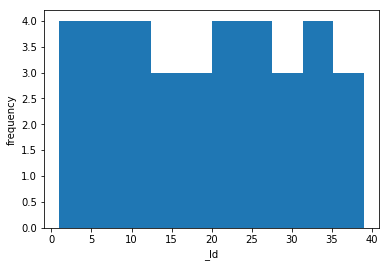

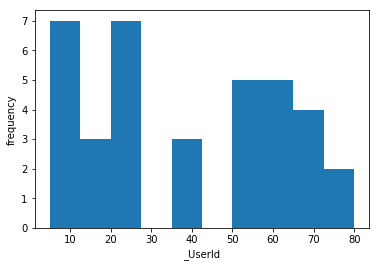

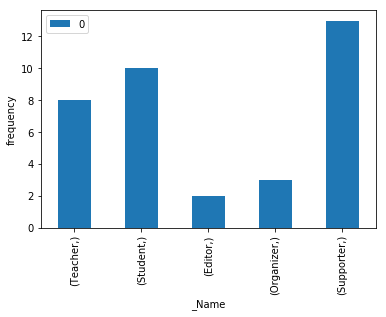

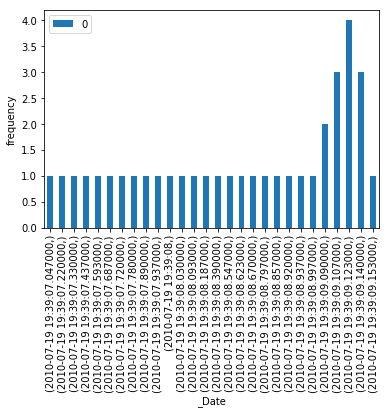

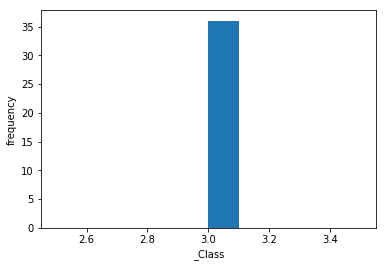

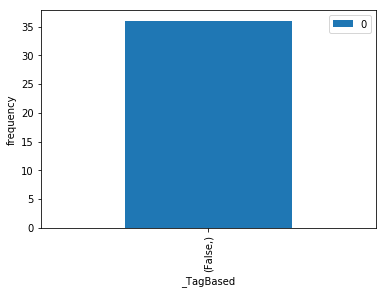

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Badges.csv
_type = [('_Id', 'int'), ('_UserId', 'int'), ('_Name', 'string'), ('_Date', 'timestamp'), ('_Class', 'int'), ('_TagBased', 'boolean')]
valueDistribution = [(array([4., 4., 4., 3., 3., 4., 4., 3., 4., 3.]), array([ 1. ,  4.8,  8.6, 12.4, 16.2, 20. , 23.8, 27.6, 31.4, 35.2, 39. ]), <a list of 10 Patch objects>), (array([7., 3., 7., 0., 3., 0., 5., 5., 4., 2.]), array([ 5. , 12.5, 20. , 27.5, 35. , 42.5, 50. , 57.5, 65. , 72.5, 80. ]), <a list of 10 Patch objects>),                0
(Teacher,)     8
(Student,)    10
(Editor,)      2
(Organizer,)   3
(Supporter,)  13,                                0
(2010-07-19 19:39:07.047000,)  1
(2010-07-19 19:39:07.220000,)  1
(2010-07-19 19:39:07.330000,)  1
(2010-07-19 19:39:07.437000,)  1
(2010-07-19 19:39:07.593000,)  1
(2010-07-19 19:39:07.687000,)  1
(2010-07-19 19:39:07.720000,)  1
(2010-07-19 19:39:07.780000,)  1
(2010-07-19 19:39:07.8900

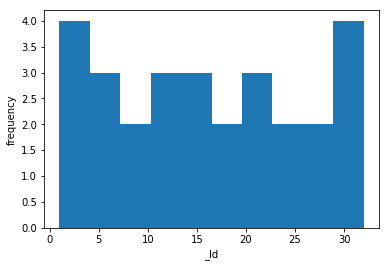

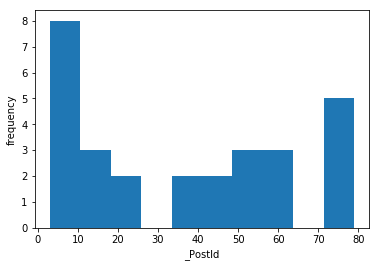

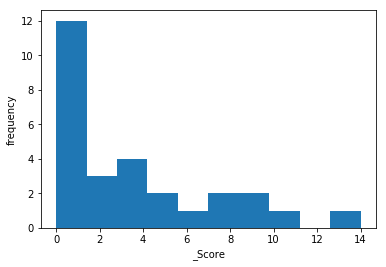

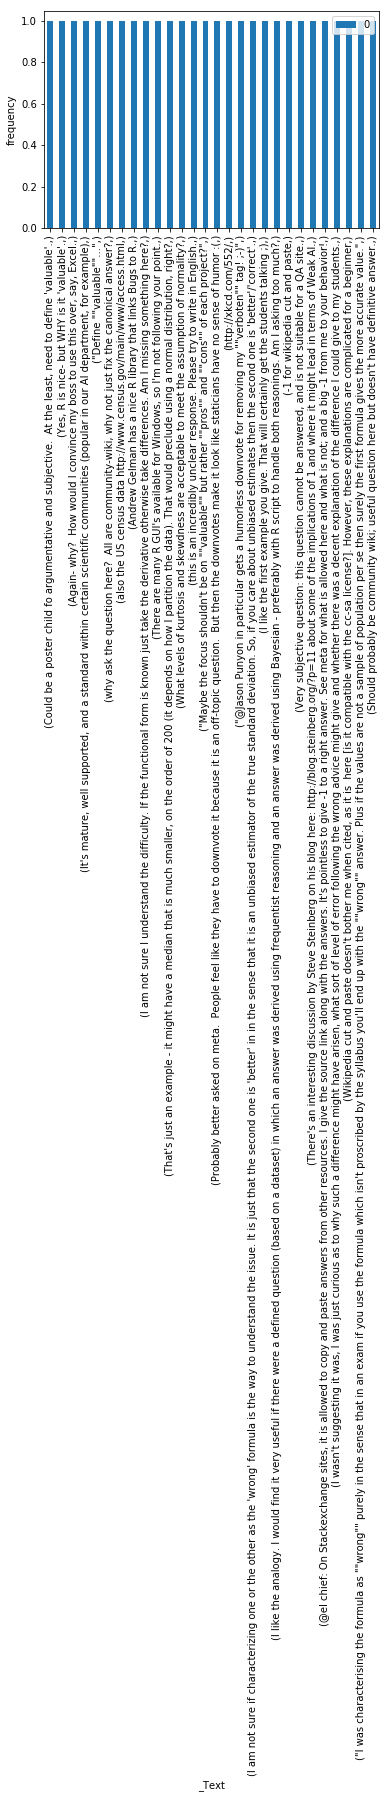

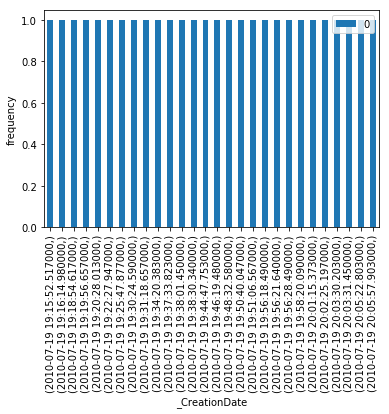

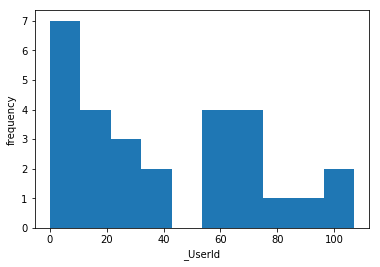

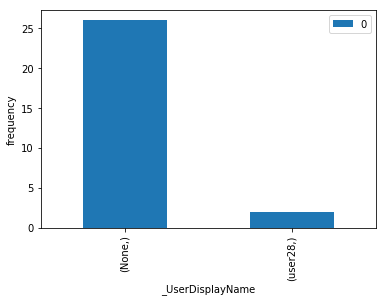

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Comments.csv
_type = [('_Id', 'int'), ('_PostId', 'int'), ('_Score', 'int'), ('_Text', 'string'), ('_CreationDate', 'timestamp'), ('_UserId', 'int'), ('_UserDisplayName', 'string')]
valueDistribution = [(array([4., 3., 2., 3., 3., 2., 3., 2., 2., 4.]), array([ 1. ,  4.1,  7.2, 10.3, 13.4, 16.5, 19.6, 22.7, 25.8, 28.9, 32. ]), <a list of 10 Patch objects>), (array([8., 3., 2., 0., 2., 2., 3., 3., 0., 5.]), array([ 3. , 10.6, 18.2, 25.8, 33.4, 41. , 48.6, 56.2, 63.8, 71.4, 79. ]), <a list of 10 Patch objects>), (array([12.,  3.,  4.,  2.,  1.,  2.,  2.,  1.,  0.,  1.]), array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]), <a list of 10 Patch objects>),                                                     0
(Could be a poster child fo argumentative and s...  1
(Yes, R is nice- but WHY is it 'valuable'.,)        1
(Again- why?  How would I convince my boss to u...  1
(It's m

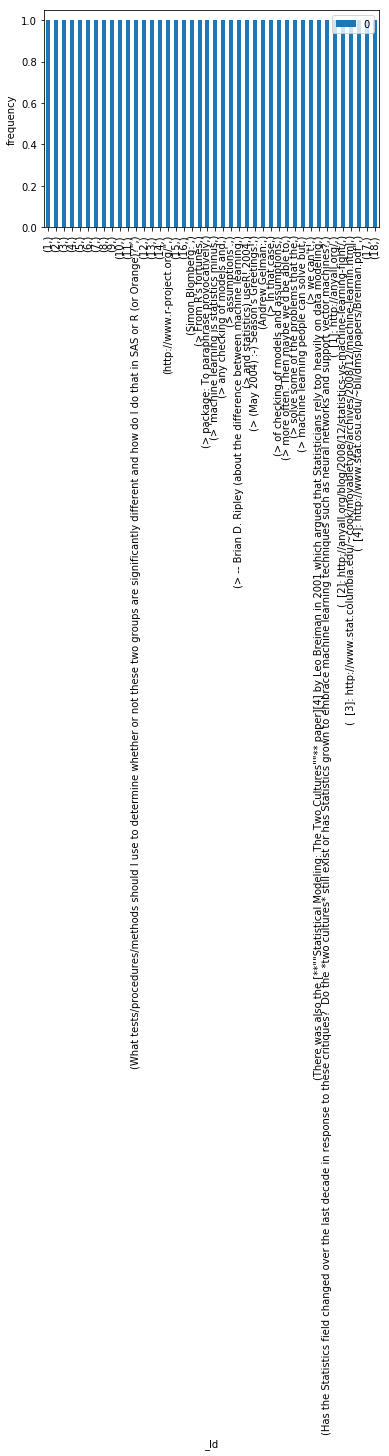

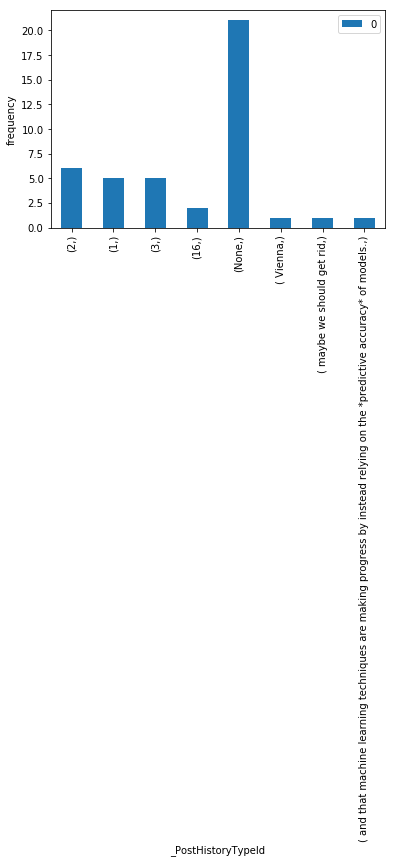

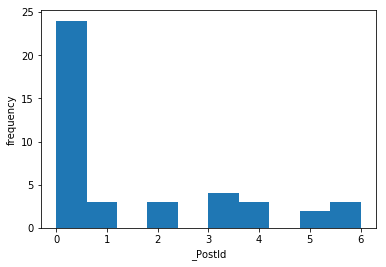

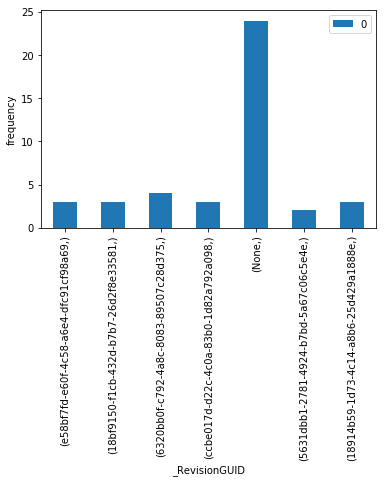

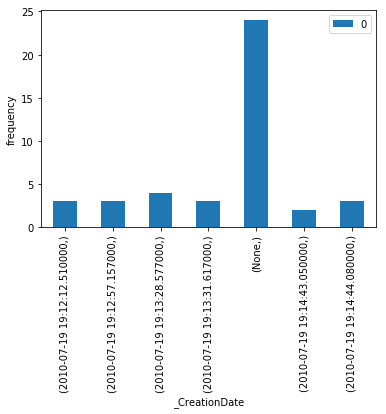

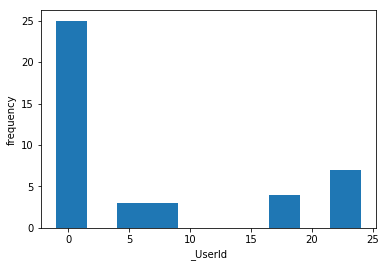

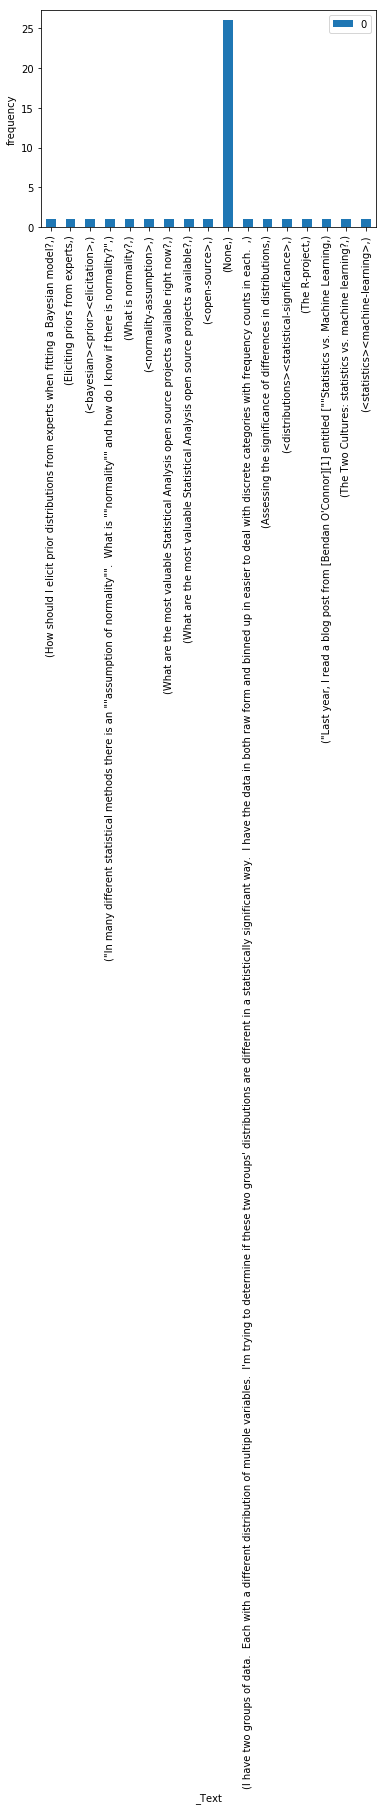

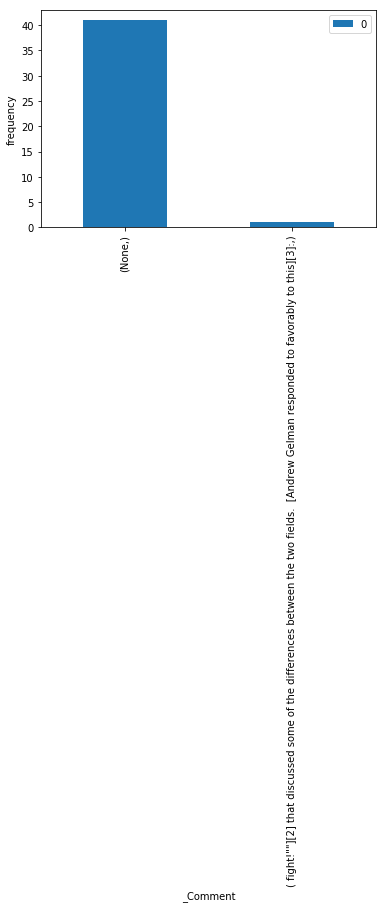

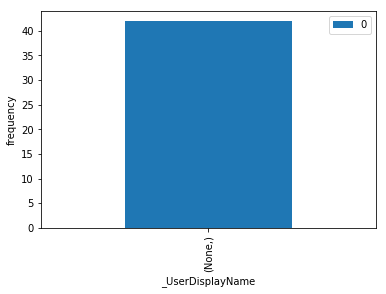

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/PostHistory.csv
_type = [('_Id', 'string'), ('_PostHistoryTypeId', 'string'), ('_PostId', 'int'), ('_RevisionGUID', 'string'), ('_CreationDate', 'timestamp'), ('_UserId', 'int'), ('_Text', 'string'), ('_Comment', 'string'), ('_UserDisplayName', 'string')]
valueDistribution = [                                                    0
(1,)                                                1
(2,)                                                1
(3,)                                                1
(4,)                                                1
(5,)                                                1
(6,)                                                1
(7,)                                                1
(8,)                                                1
(9,)                                                1
(10,)                                               1
(11,)                            

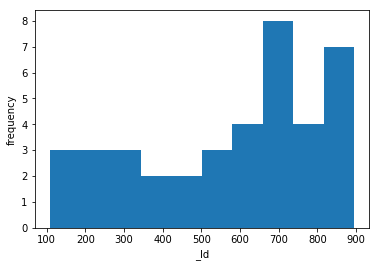

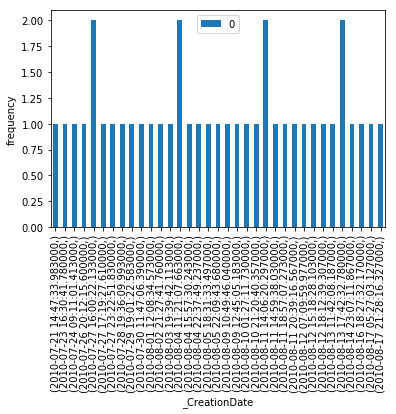

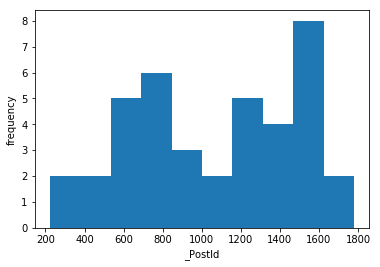

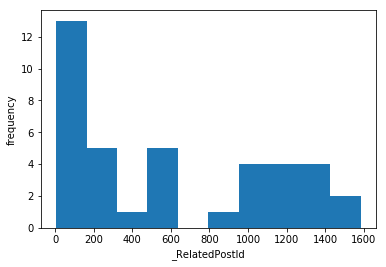

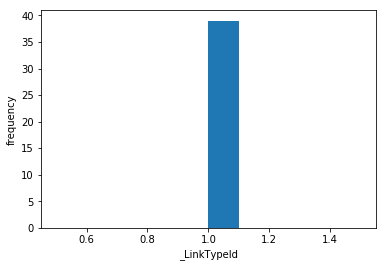

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/PostLinks.csv
_type = [('_Id', 'int'), ('_CreationDate', 'timestamp'), ('_PostId', 'int'), ('_RelatedPostId', 'int'), ('_LinkTypeId', 'int')]
valueDistribution = [(array([3., 3., 3., 2., 2., 3., 4., 8., 4., 7.]), array([108. , 186.7, 265.4, 344.1, 422.8, 501.5, 580.2, 658.9, 737.6,
       816.3, 895. ]), <a list of 10 Patch objects>),                                0
(2010-07-21 14:47:33.983000,)  1
(2010-07-23 16:30:41.780000,)  1
(2010-07-24 09:11:01.413000,)  1
(2010-07-26 20:12:15.600000,)  1
(2010-07-27 16:00:22.133000,)  2
(2010-07-27 17:19:27.610000,)  1
(2010-07-27 23:22:51.830000,)  1
(2010-07-28 19:36:09.993000,)  1
(2010-07-29 19:01:22.583000,)  1
(2010-07-30 11:47:06.390000,)  1
(2010-08-01 12:08:34.573000,)  1
(2010-08-02 21:27:41.760000,)  1
(2010-08-03 19:39:42.113000,)  1
(2010-08-04 11:21:07.663000,)  2
(2010-08-04 15:57:30.243000,)  1
(2010-08-04 22:37:49.237000,)  1
(2010-

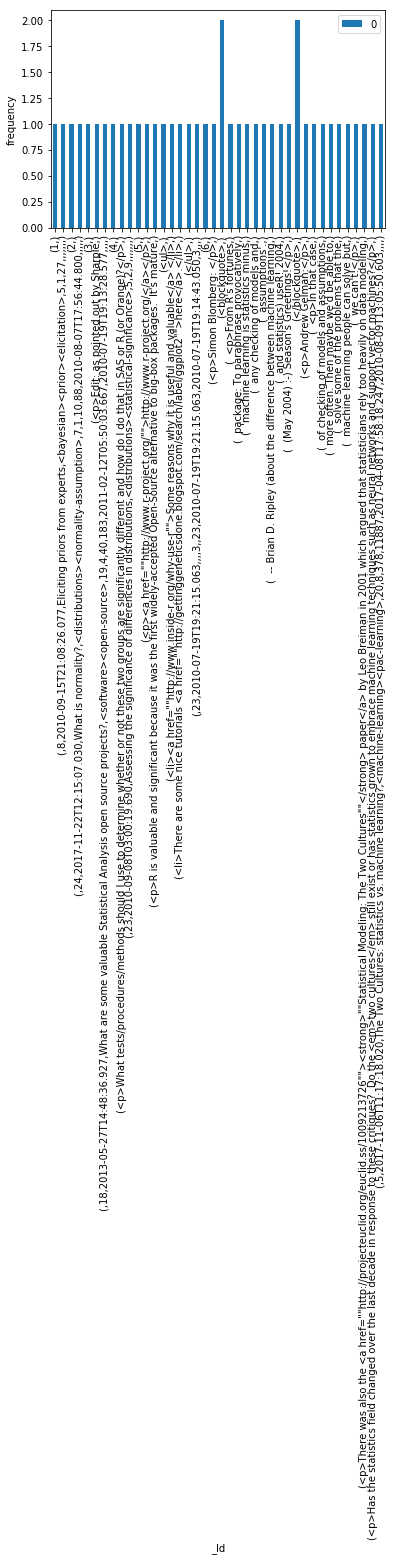

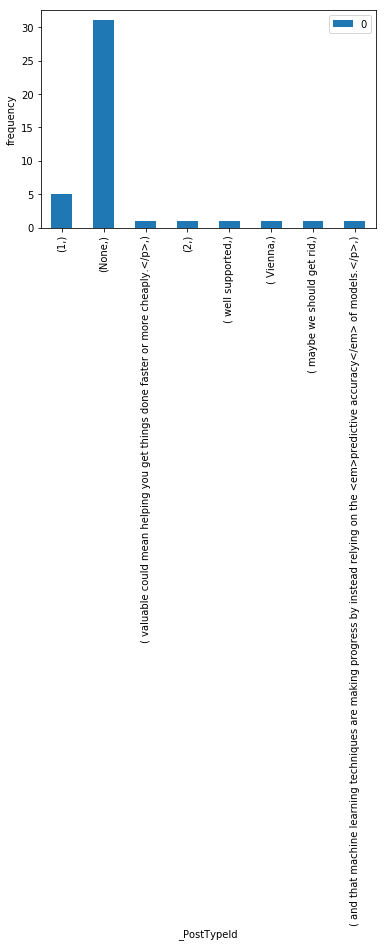

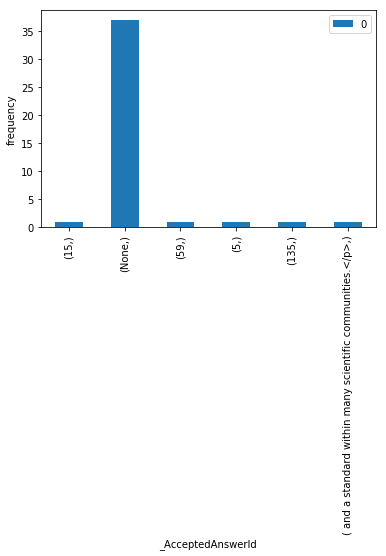

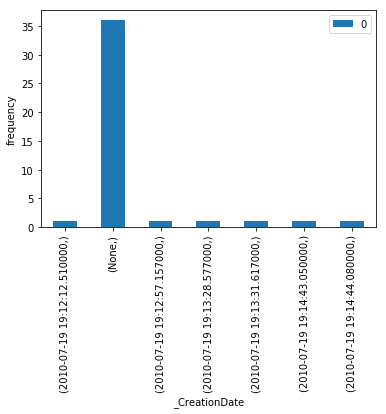

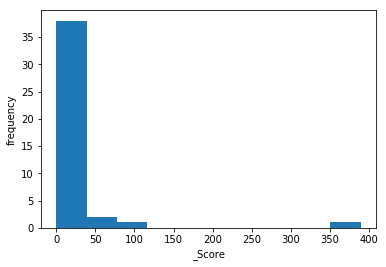

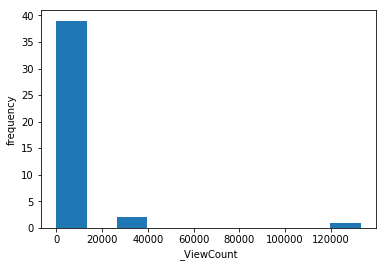

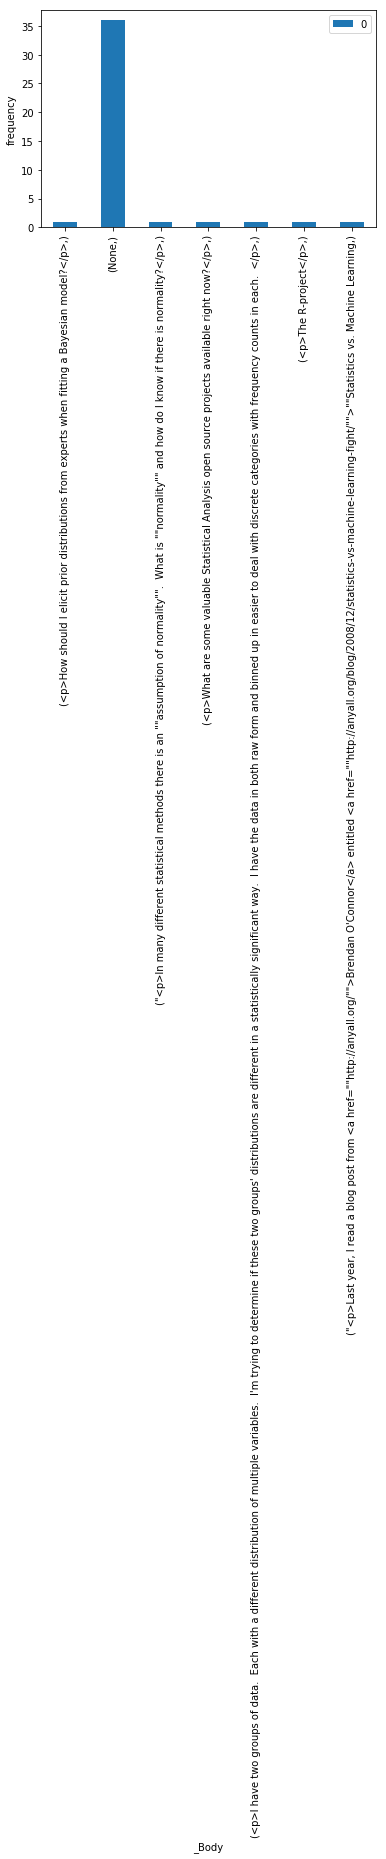

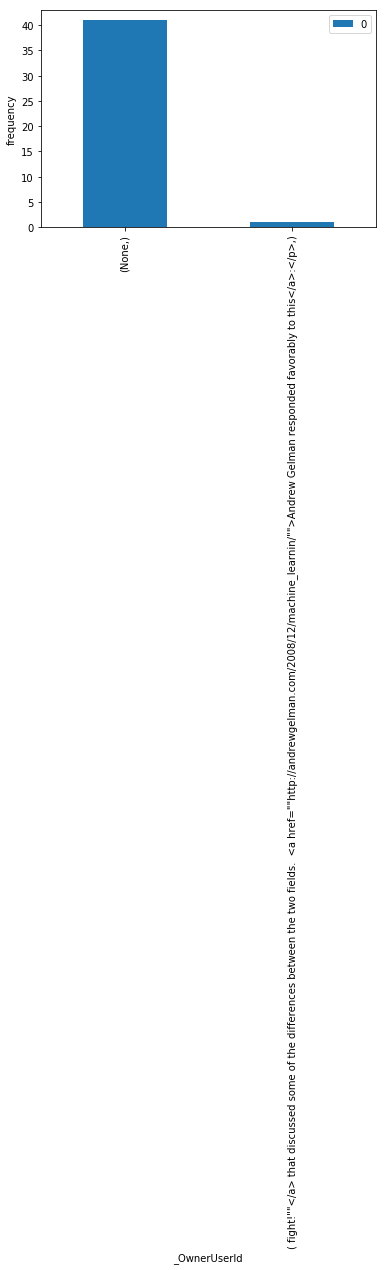

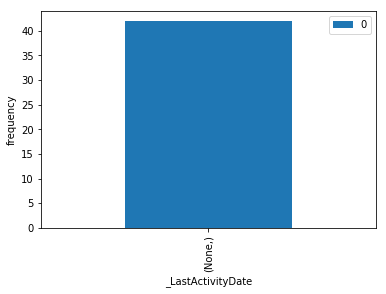

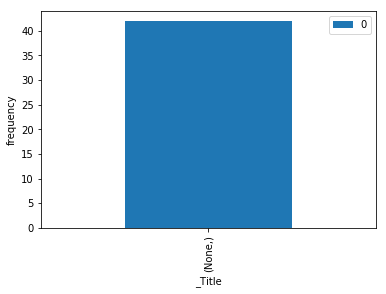

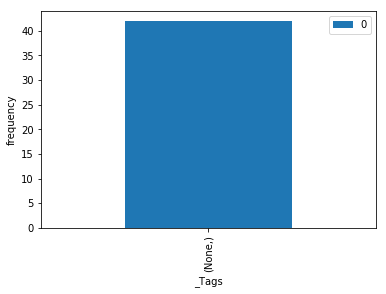

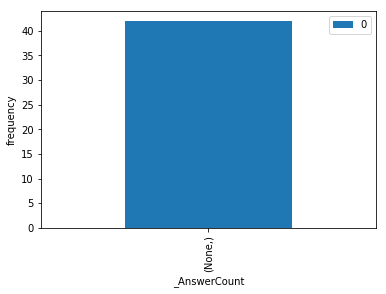

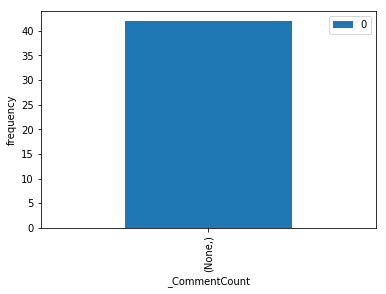

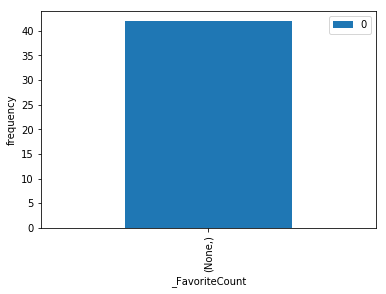

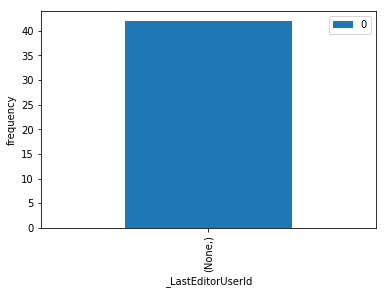

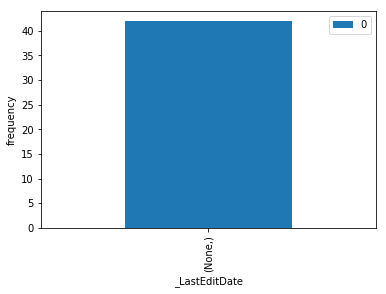

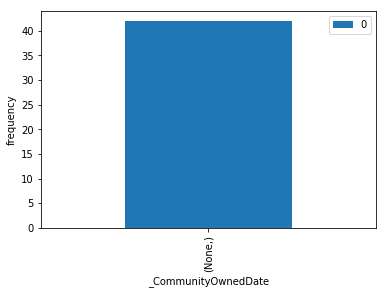

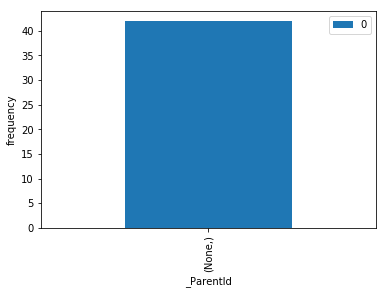

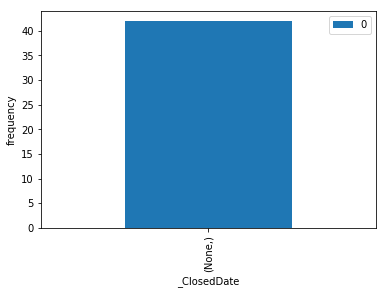

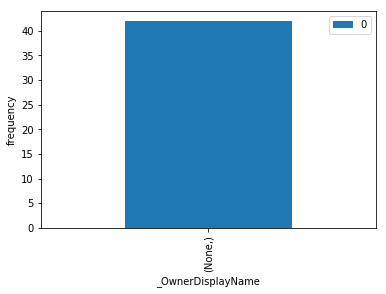

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Posts.csv
_type = [('_Id', 'string'), ('_PostTypeId', 'string'), ('_AcceptedAnswerId', 'string'), ('_CreationDate', 'timestamp'), ('_Score', 'int'), ('_ViewCount', 'int'), ('_Body', 'string'), ('_OwnerUserId', 'string'), ('_LastActivityDate', 'string'), ('_Title', 'string'), ('_Tags', 'string'), ('_AnswerCount', 'string'), ('_CommentCount', 'string'), ('_FavoriteCount', 'string'), ('_LastEditorUserId', 'string'), ('_LastEditDate', 'string'), ('_CommunityOwnedDate', 'string'), ('_ParentId', 'string'), ('_ClosedDate', 'string'), ('_OwnerDisplayName', 'string')]
valueDistribution = [                                                    0
(1,)                                                1
(,8,2010-09-15T21:08:26.077,Eliciting priors fr...  1
(2,)                                                1
(,24,2017-11-22T12:15:07.030,What is normality?...  1
(3,)                                           

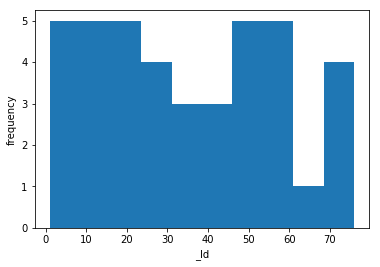

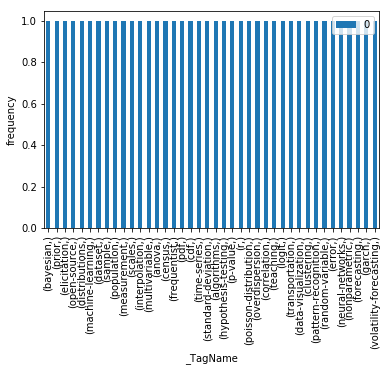

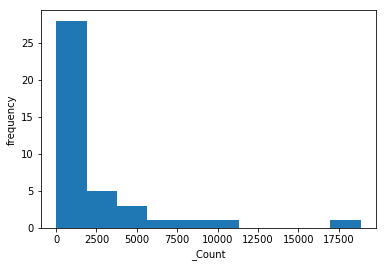

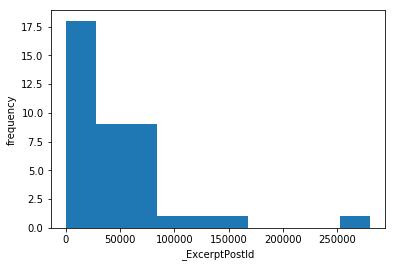

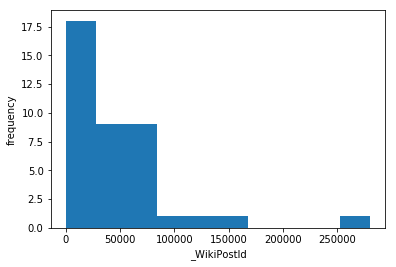

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Tags.csv
_type = [('_Id', 'int'), ('_TagName', 'string'), ('_Count', 'int'), ('_ExcerptPostId', 'int'), ('_WikiPostId', 'int')]
valueDistribution = [(array([5., 5., 5., 4., 3., 3., 5., 5., 1., 4.]), array([ 1. ,  8.5, 16. , 23.5, 31. , 38.5, 46. , 53.5, 61. , 68.5, 76. ]), <a list of 10 Patch objects>),                            0
(bayesian,)                1
(prior,)                   1
(elicitation,)             1
(open-source,)             1
(distributions,)           1
(machine-learning,)        1
(dataset,)                 1
(sample,)                  1
(population,)              1
(measurement,)             1
(scales,)                  1
(interpolation,)           1
(multivariable,)           1
(anova,)                   1
(census,)                  1
(frequentist,)             1
(pdf,)                     1
(cdf,)                     1
(time-series,)             1
(standard-deviation

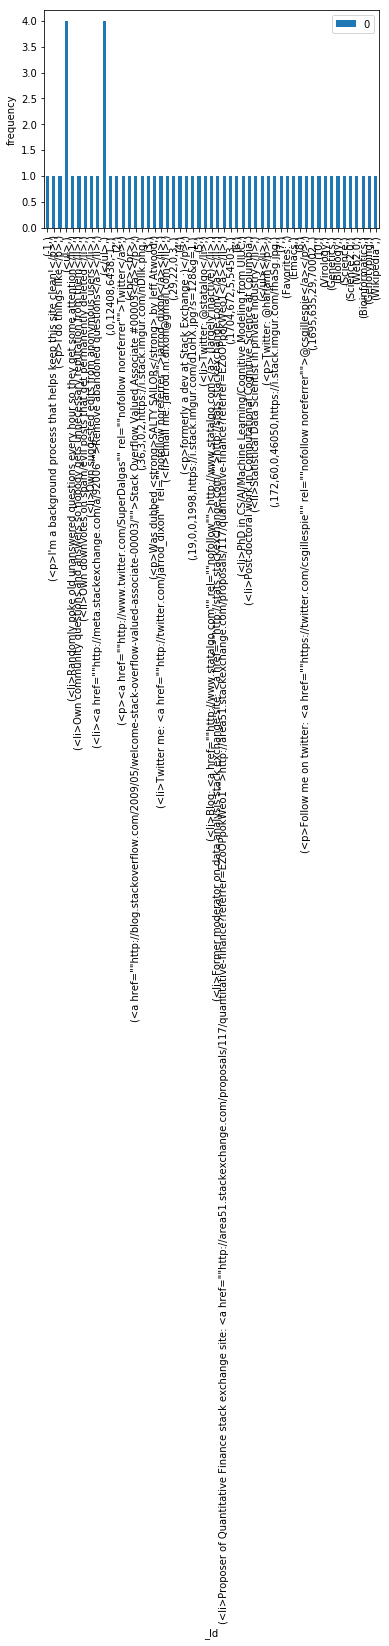

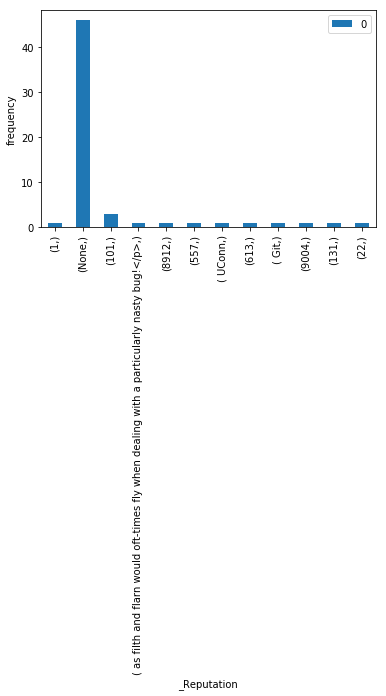

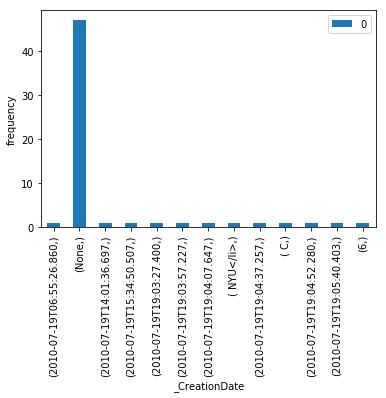

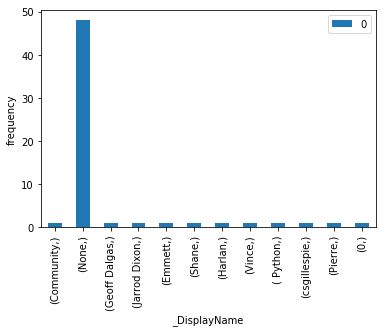

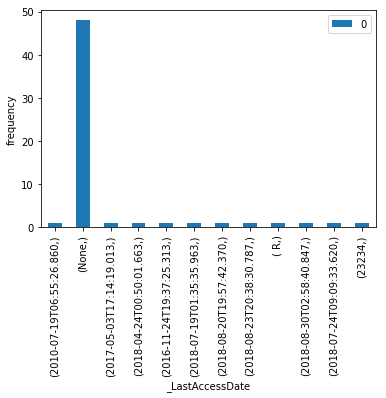

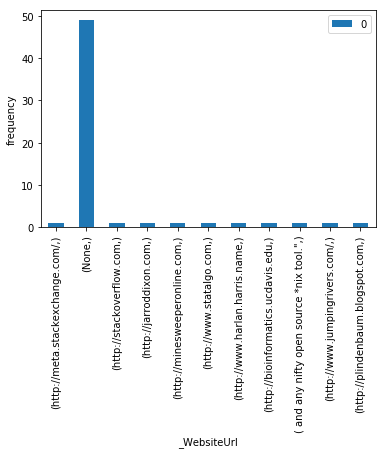

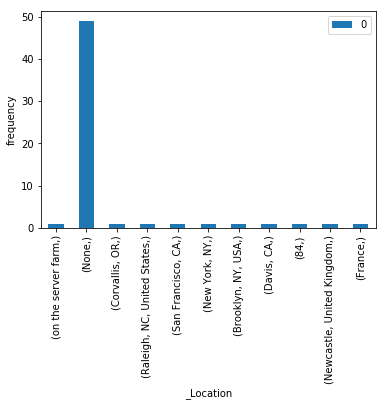

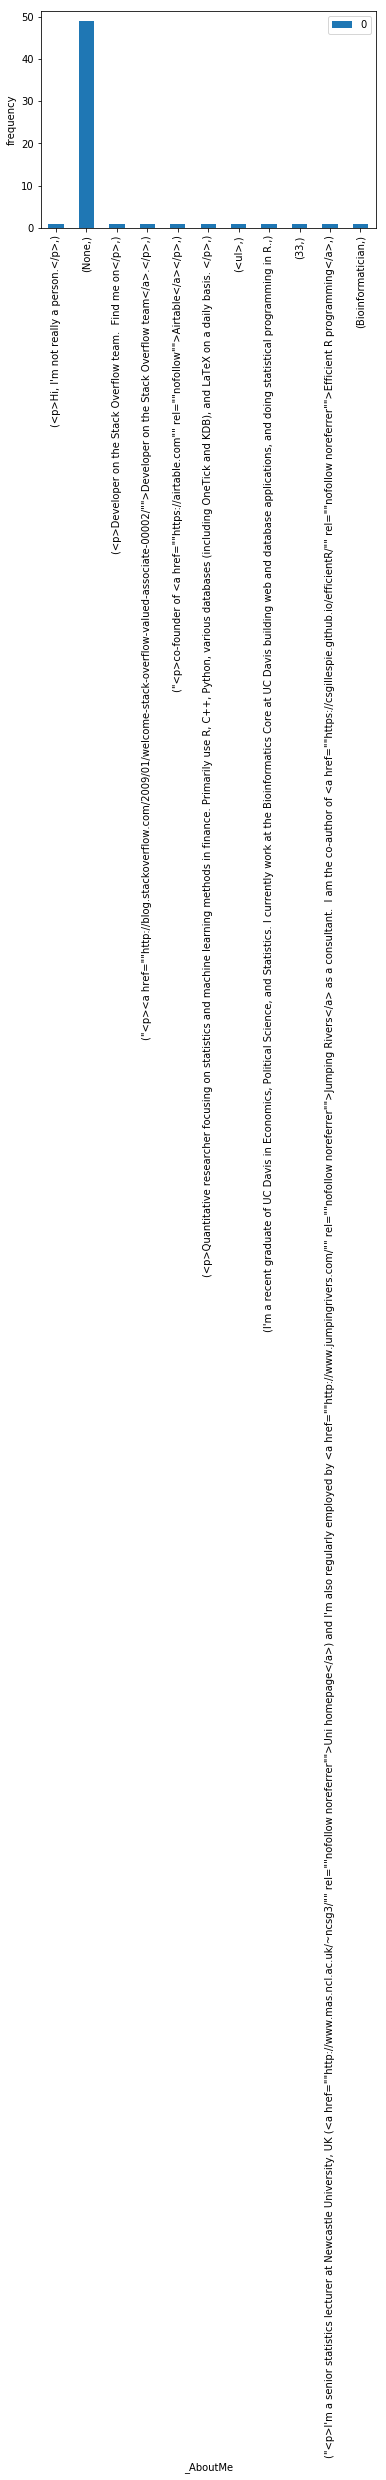

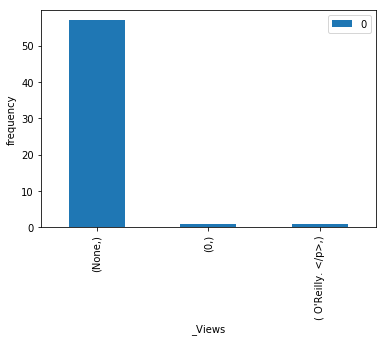

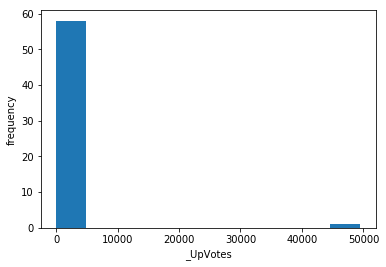

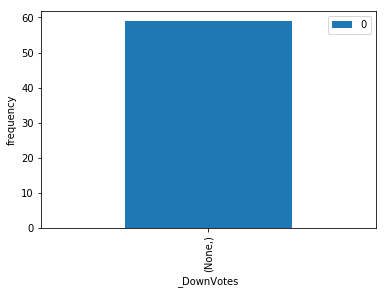

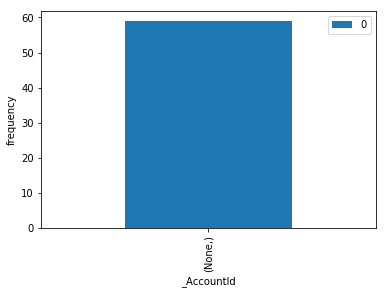

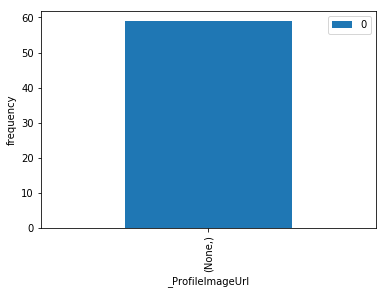

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Users.csv
_type = [('_Id', 'string'), ('_Reputation', 'string'), ('_CreationDate', 'string'), ('_DisplayName', 'string'), ('_LastAccessDate', 'string'), ('_WebsiteUrl', 'string'), ('_Location', 'string'), ('_AboutMe', 'string'), ('_Views', 'string'), ('_UpVotes', 'int'), ('_DownVotes', 'string'), ('_AccountId', 'string'), ('_ProfileImageUrl', 'string')]
valueDistribution = [                                                    0
(-1,)                                               1
(<p>I'm a background process that helps keep th...  1
(<p>I do things like</p>,)                          1
(<ul>,)                                             4
(<li>Randomly poke old unanswered questions eve...  1
(<li>Own community questions and answers so nob...  1
(<li>Own downvotes on spam/evil posts that get ...  1
(<li>Own suggested edits from anonymous users</...  1
(<li><a href=""http://meta.stackexchange.

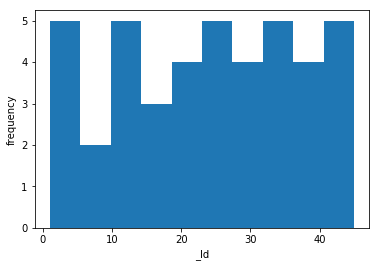

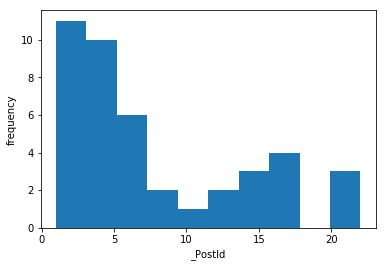

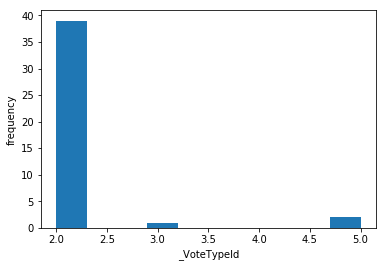

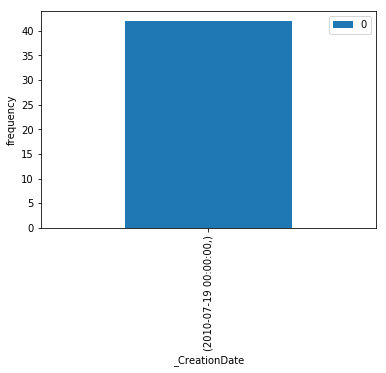

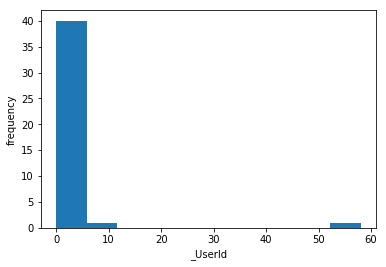

_id = http://hdr.undp.org/en/indicators/137506#
name = /test/stackexchange/release_09-10-18/cut/Votes.csv
_type = [('_Id', 'int'), ('_PostId', 'int'), ('_VoteTypeId', 'int'), ('_CreationDate', 'timestamp'), ('_UserId', 'int')]
valueDistribution = [(array([5., 2., 5., 3., 4., 5., 4., 5., 4., 5.]), array([ 1. ,  5.4,  9.8, 14.2, 18.6, 23. , 27.4, 31.8, 36.2, 40.6, 45. ]), <a list of 10 Patch objects>), (array([11., 10.,  6.,  2.,  1.,  2.,  3.,  4.,  0.,  3.]), array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]), <a list of 10 Patch objects>), (array([39.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  2.]), array([2. , 2.3, 2.6, 2.9, 3.2, 3.5, 3.8, 4.1, 4.4, 4.7, 5. ]), <a list of 10 Patch objects>),                          0
(2010-07-19 00:00:00,)  42, (array([40.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]), array([0.0, 5.8, 11.6, 17.4, 23.2, 29.0, 34.8, 40.6, 46.4,
       52.199999999999996, 58.0], dtype=object), <a list of 10 Patch objects>)]
nullValue = [0, 0, 0,

In [45]:
from matplotlib import pyplot as plt 
attributesList = []
index = 0

for f in listFilePath:  
    fullPath = f 
                                    # _id, name, _type, valueDistribution, nullValue, absentValue, 
                                    # minValue, maxValue, mean, median, mode, count):
    attributes = AttributeDescriptor('http://hdr.undp.org/en/indicators/137506#', f, getType(fullPath), getHist(fullPath), getNull(fullPath), 
                                     getAbsent(fullPath), getMinVal(fullPath), getMaxVal(fullPath), 
                                     getMeanVal(fullPath), getMedianVal(fullPath), getModeVal(fullPath), getCount(fullPath))    
    attributesList.append(attributes)
    attributesList[index].printInfo()
    del attributes
    index+=1      

#### Create Release View Object

In [46]:
releaseViewList = []

url="https://archive.org/download/stackexchange/stats.stackexchange.com.7z"
conn = urllib.request.urlopen(url, timeout=30)
last_modified = conn.headers['last-modified']
publicationDate = last_modified
                          #_id, version, publicationDate, size, license, attributeDescList 
releaseViewList.append(ReleaseView(url, publicationDate, None, None, None, attributesList))


#### Create View Object

In [47]:
            #_id, name, provider, author, description, code, rules, source, releaseViewList
view = View(url, None, None, None, None, None, None, None, releaseViewList)
view.printInfo()

_id = https://archive.org/download/stackexchange/stats.stackexchange.com.7z
name = None
provider = None
author = None
description = None
code = None
rules = None
source = None
list of release views = [<__main__.ReleaseView object at 0x7fec24905dd8>]


### Serialize view objet to JSON

In [49]:
import json
import jsonpickle

viewJson = jsonpickle.encode(view)
viewJson = json.loads(viewJson)

### Store view file in a MongoDB Atlas Cluster

In [50]:
import json
from pymongo import MongoClient
import gridfs

# Creates a client for the primary sandbox from cluster host cluster0-nlbcx.mongodb.net
client = MongoClient('cluster0-shard-00-00-nlbcx.mongodb.net:27017',
                      username='adminUser',
                      password='xpass',
                      authSource='admin',                      
                      replicaSet='Cluster0-shard-0',
                      ssl=True,
                      retryWrites=True)

db = client.test 
db = client.test_database
db = client['viewModel-db']
#collection = db['viewModel-view4']

fs = gridfs.GridFS(db, collection = 'viewModel-view8', disable_md5=False)

#pid = collection.insert_one(viewJson).inserted_id  # this id can replace the url in datacollectionmodel class
did = fs.put(str(viewJson), encoding='utf8')
print (did)

client.close()

5bc74142d10f15013bb26f7e
